# LOAD AND PRE-PROCESS THE DATA


In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt



In [3]:
path = "drive/MyDrive/DATA_RL/2019Floor6.csv"
df = pd.read_csv(path)


In [4]:
df[["year","Month","reste"]] = df["Date"].str.split("-", expand = True)
df=df[df['reste'].str.contains(':00:00$', na=False)]
df["reste2"]=df["reste"].str.split(":")
df["day"]=df["reste2"].str[0].str[:2]
df["Hour"]=df["reste2"].str[0].str[2:]
df=df.drop(columns=['reste', 'reste2','year','day'])
df=df.reset_index()
df["Day Type"]=df.index % 7
df["Daylight Savings Status"]=0.0
df["Indoor Temperature [C]"]=df[['z1_S1(degC)', 'z2_S1(degC)','z4_S1(degC)','z5_S1(degC)']].mean(axis=1)
df["Average Unmet Cooling Setpoint Difference [C]"]=0.0
df["Indoor Relative Humidity [%]"]=df[['z1_S1(RH%)', 'z2_S1(RH%)','z4_S1(RH%)','z5_S1(RH%)']].mean(axis=1)
df["Equipment Electric Power [kWh]"]=df[['z1_Light(kW)', 'z1_Plug(kW)','z2_Light(kW)', 'z2_Plug(kW)','z3_Light(kW)', 'z3_Plug(kW)','z4_Light(kW)', 'z4_Plug(kW)','z5_Light(kW)', 'z5_Plug(kW)']].sum(axis=1)
df["DHW Heating [kWh]"]=0.0
df["Cooling Load [kWh]"]=df[['z1_AC1(kW)', 'z2_AC1(kW)','z4_AC1(kW)','z4_AC2(kW)','z4_AC3(kW)','z4_AC4(kW)','z5_AC1(kW)']].sum(axis=1)

df=df[df["Indoor Temperature [C]"].notnull()]
df=df[df["Indoor Relative Humidity [%]"].notnull()]
df=df[df["Equipment Electric Power [kWh]"].notnull()]
df=df[df["Cooling Load [kWh]"].notnull()]

#df.head(61)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [5]:
df_final=df[["Date","Month", "Hour","Day Type","Daylight Savings Status","Indoor Temperature [C]","Average Unmet Cooling Setpoint Difference [C]","Indoor Relative Humidity [%]","Equipment Electric Power [kWh]","DHW Heating [kWh]","Cooling Load [kWh]"]]

In [6]:
df_final.head(10)

,Date,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature [C],Average Unmet Cooling Setpoint Difference [C],Indoor Relative Humidity [%],Equipment Electric Power [kWh],DHW Heating [kWh],Cooling Load [kWh]
1552,2019-03-06 16:00:00,03,16,5,0.0,21.742500,0.0,61.995000,22.54,0.0,62.21
1553,2019-03-06 17:00:00,03,17,6,0.0,24.583333,0.0,55.223333,21.74,0.0,0.00
1554,2019-03-06 18:00:00,03,18,0,0.0,25.667500,0.0,57.400000,18.67,0.0,0.00
1555,2019-03-06 19:00:00,03,19,1,0.0,25.910000,0.0,59.005000,14.66,0.0,0.00
1556,2019-03-06 20:00:00,03,20,2,0.0,25.767500,0.0,60.430000,12.91,0.0,0.00
1557,2019-03-06 21:00:00,03,21,3,0.0,25.540000,0.0,61.927500,0.95,0.0,0.00
1558,2019-03-06 22:00:00,03,22,4,0.0,25.320000,0.0,63.520000,0.79,0.0,0.00
1559,2019-03-06 23:00:00,03,23,5,0.0,25.245000,0.0,64.635000,0.65,0.0,0.00
1560,2019-03-07 00:00:00,03,00,6,0.0,25.222500,0.0,65.435000,0.62,0.0,0.00
1561,2019-03-07 01:00:00,03,01,0,0.0,25.185000,0.0,66.097500,0.61,0.0,0.00


In [7]:
df_final.to_csv(r'drive/MyDrive/DATA_RL/Building_1.csv',index=False)

In [8]:
df_final.count()

Month                                            5507
Hour                                             5507
Day Type                                         5507
Daylight Savings Status                          5507
Indoor Temperature [C]                           5507
Average Unmet Cooling Setpoint Difference [C]    5507
Indoor Relative Humidity [%]                     5507
Equipment Electric Power [kWh]                   5507
DHW Heating [kWh]                                5507
Cooling Load [kWh]                               5507
dtype: int64

In [9]:
#CREATE THE OTHERS DATASET TO BE ABLE TO CREATE THE ENV, BUT I WILL NOT USE THEM 

path = "drive/MyDrive/DATA_RL/solar_generation_1kW.csv"
df = pd.read_csv(path)
df=df.head(5507)
df.to_csv(r'drive/MyDrive/DATA_RL/solar_generation_1kW.csv',index=False)

path = "drive/MyDrive/DATA_RL/carbon_intensity.csv"
df = pd.read_csv(path)
df=df.head(5507)
df.to_csv(r'drive/MyDrive/DATA_RL/carbon_intensity.csv',index=False)

path = "drive/MyDrive/DATA_RL/weather_data.csv"
df = pd.read_csv(path)
df=df.head(5507)
df.to_csv(r'drive/MyDrive/DATA_RL/weather_data.csv',index=False)




#CREATE THE ENVIRONEMENT

In [7]:
%cd drive/'MyDrive/DATA_RL/'
from citylearn import CityLearn
from pathlib import Path
import numpy as np                                                                                                                                                                                      
import torch
import matplotlib.pyplot as plt

/content/drive/MyDrive/DATA_RL


In [56]:
##CREATE THE ENVIRONEMENT

buildings = ["Building_1"]

sim_period = (0, 5507*1-1)
params = {'data_path':Path(""), 
        'building_attributes':'building_attributes.json', 
        'weather_file':'weather_data.csv', 
        'solar_profile':'solar_generation_1kW.csv', 
        'carbon_intensity':'carbon_intensity.csv',
        'building_ids':buildings,
        'buildings_states_actions':'buildings_state_action_space.json', 
        'simulation_period': sim_period,
        'cost_function': ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption'], 
        'central_agent': False,
        'save_memory': False }

env = CityLearn(**params)

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#THE LIST OF STATE IS : MONTH, DAY, HOUR, T_IN, RH_IN, ELECTRICAL_STORAGE_SOC, NET_ELECTRICITY_CONSUMPTION
OBSERVATION_SIZE=env.observation_space.shape[0]

#THE ACTIONS ARE : COOLING_STORAGE AND ELECTRICAL_STORAGE
ACTION_SIZE=env.action_space.shape[0]


#CREATE THE NETWORKS

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

class DQNPOLICY(nn.Module):

    def __init__(self):
        super(DQNPOLICY, self).__init__()
        self.linear1=nn.Linear(OBSERVATION_SIZE,400)
        self.linear2=nn.Linear(400,200)
        self.linear3=nn.Linear(200,100)
        self.linear4=nn.Linear(100,ACTION_SIZE)
        self.linear5=nn.Linear(100,ACTION_SIZE)

        self.sig=nn.Sigmoid()
        self.normLayer1 = nn.LayerNorm(400)
        self.normLayer2 = nn.LayerNorm(200)

        self.dropout=nn.Dropout(p=0.2)

       

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        #x=self.dropout(x)

        out1=self.linear4(x)
        out2=self.linear5(x)
        log_pi=torch.clamp(out2, min=-20, max=2)

        return out1 , log_pi


class DQNQVALUE(nn.Module):

    def __init__(self):
        super(DQNQVALUE, self).__init__()
        self.linear1=nn.Linear(OBSERVATION_SIZE+ACTION_SIZE,400)
        self.linear2=nn.Linear(400,200)
        self.linear3=nn.Linear(200,100)
        self.linear4=nn.Linear(100,1)
        self.normLayer1 = nn.LayerNorm(400)
        self.normLayer2 = nn.LayerNorm(200)
        self.normLayer3 = nn.LayerNorm(100)
        self.sig=nn.Sigmoid()

        self.dropout=nn.Dropout(p=0.2)

    def forward(self, x):
        x = x.to(device)
        x = (self.normLayer1(F.relu(self.linear1(x))))
        x = (self.normLayer2(F.relu(self.linear2(x))))
        x = (self.normLayer3(F.relu(self.linear3(x))))
       # x=self.dropout(x)
        return self.linear4(x)

#CREATE THE MEMORY

In [59]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
     
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

#INIT THE NETWORKS

In [75]:
BATCH_SIZE = 64
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TAU=1e-4
LR=1e-7
ALPHA =0.2
#creation of the networks

policy_net = DQNPOLICY().to(device)
policy_net_target = DQNPOLICY().to(device)

Q_value_net = DQNQVALUE().to(device)
Q_value_net_target = DQNQVALUE().to(device)


policy_net.train()
Q_value_net.train()

policy_net_target.eval()
Q_value_net_target.eval()

#creation of the optimizers
optimizer_policy = optim.Adam(policy_net.parameters(),LR)
optimizer_Q_Value= optim.Adam(Q_value_net.parameters(),LR)

#init the memory
memory = ReplayMemory(int(1e5))

steps_done = 0


#function to select the action to do

def select_action(state,env):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            out,_=policy_net(state)
            return out
    else:
        a=torch.tensor(env.action_space.sample())
        return a


#CREATE THE OPTIMIZATION FUNCTION

In [76]:

#function to optimize the model

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    # Generate the batch
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    

    state_batch = torch.cat(batch.state).to(device)
    action_batch = torch.cat(batch.action).to(device)
    reward_batch = torch.cat(batch.reward).to(device)
    next_state_batch = torch.cat(batch.next_state).to(device)



    # Compute Expected Q values

    state_batch=state_batch.reshape((-1,OBSERVATION_SIZE))
    action_batch = action_batch.reshape((-1,ACTION_SIZE))
    reward_batch = reward_batch.reshape((-1,1))
    next_state_batch = next_state_batch.reshape((-1,OBSERVATION_SIZE))

    
    
    with torch.no_grad():
        next_state_action,_=(policy_net_target(next_state_batch))
        next_state_and_action=torch.cat([next_state_batch, next_state_action], 1)
        target_q_values = Q_value_net_target(next_state_and_action.to(device)) 

        expected_Q_values=reward_batch + (1 - done) * GAMMA * target_q_values.reshape((-1,1))

    # Compute Predicted Q values

    state_and_action=torch.cat([state_batch, action_batch], 1)
    Q_pred=Q_value_net(state_and_action)

    
    # UPDATE THE LOCAL Q_VALUE_NETWORK

    criterion = nn.HuberLoss()
    loss = criterion(Q_pred, expected_Q_values)
    
    
    optimizer_Q_Value.zero_grad()
    loss.backward()
    optimizer_Q_Value.step()


    #UPDATE THE LOCAL POLICY NETWORK

    new_actions,log_pi = policy_net(state_batch)
    new_state_and_action=torch.cat([state_batch, new_actions], 1)
    new_Q_values=Q_value_net(new_state_and_action)

    policy_loss = (ALPHA*log_pi - new_Q_values).mean()

    

    optimizer_policy.zero_grad()
    policy_loss.backward()
    optimizer_policy.step()

    #UPDATE_TARGET_MODEL
    for target_param, param in zip(Q_value_net_target.parameters(), Q_value_net.parameters()):
                        target_param.data.copy_(
                           target_param.data * (1.0 - TAU) + param.data * TAU
                        )
    for target_param, param in zip(policy_net_target.parameters(), policy_net.parameters()):
                        target_param.data.copy_(
                           target_param.data * (1.0 - TAU) + param.data * TAU
                        )


In [77]:
def normalize (X,max,min):
  return (X-min)/(max-min)

#TRAIN LOOP

##THE OPTIMIZED MODEL

{'ramping': 1.2885286, '1-load_factor': 0.946359525529853, 'average_daily_peak': 1.3086449, 'peak_demand': 1.9407613, 'net_electricity_consumption': 1.0193434, 'total': 1.3007275363620743, 'coordination_score': 1.3710735764126758}


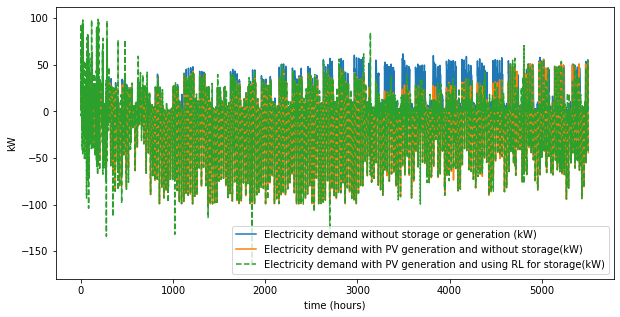

{'ramping': 1.1290987, '1-load_factor': 0.9165950275785405, 'average_daily_peak': 1.2024809, 'peak_demand': 2.0585809, 'net_electricity_consumption': 0.9599852, 'total': 1.253348133113517, 'coordination_score': 1.3266888672442902}


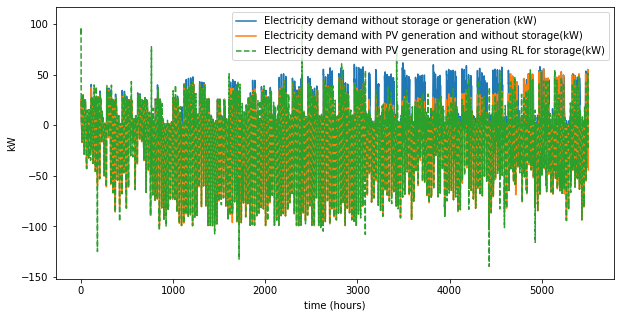

{'ramping': 1.0982879, '1-load_factor': 0.9231047412168025, 'average_daily_peak': 1.1251458, 'peak_demand': 2.0234017, 'net_electricity_consumption': 0.9303732, 'total': 1.2200626806499766, 'coordination_score': 1.2924850528540968}


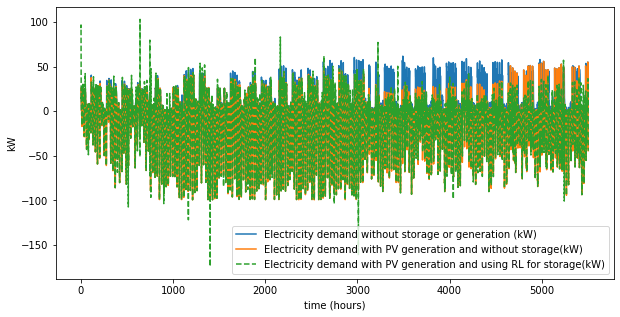

{'ramping': 1.0790967, '1-load_factor': 0.92840927369735, 'average_daily_peak': 1.1001115, 'peak_demand': 1.8998653, 'net_electricity_consumption': 0.9114753, 'total': 1.183791600718779, 'coordination_score': 1.2518706757012539}


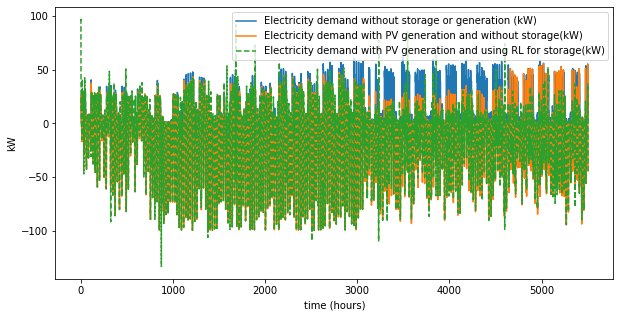

{'ramping': 1.0447158, '1-load_factor': 0.9245933891822133, 'average_daily_peak': 1.0235826, 'peak_demand': 1.9308143, 'net_electricity_consumption': 0.87524277, 'total': 1.1597897529897936, 'coordination_score': 1.2309264988076993}


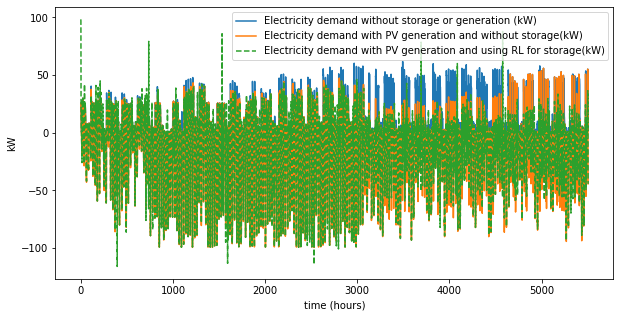

In [78]:
num_episodes = 5
i=0
cost=[]
UPDATE_EVERY=8

for i in range(num_episodes):
  # Initialize the environment and state
  done=False
  state = env.reset()[0]

  MAX=env.observation_space.high
  MIN=env.observation_space.low
  t_step = 0


  state=torch.tensor(state.astype('float32'))

  # FOR THE NORMALIZATION, I NORMALIZED ONLY THE STATES (T_IN,RH_IN,ELECTRICAL_STORAGE_SOC) 
  normalized= normalize(state[3:-1],MAX[3:-1],MIN[3:-1])
  normalized=torch.cat((state[:3],normalized),0)
  state=torch.cat((normalized,state[-1:]),0).to(device)


  while not done :
      # Select and perform an action
      action=[np.array(select_action(state,env).cpu(), dtype = 'object')]
      next_state, reward, done, _ = env.step(action)
      if done:
        break
      


      reward = torch.tensor([reward], device=device)
      action=(torch.tensor(action[0].astype('float32'))).to(device)
      next_state=next_state[0]

    

      next_state=torch.tensor(next_state.astype('float32'))

      normalized= normalize(next_state[3:-1],MAX[3:-1],MIN[3:-1])
      normalized=torch.cat((next_state[:3],normalized),0)
      next_state=torch.cat((normalized,next_state[-1:]),0).to(device)
      

      # Store the transition in memory
      memory.push(state.to(device), action.to(device), next_state, reward.to(device))

      # Move to the next state
      state = next_state

      # Otimize the network
      t_step=(t_step+1)% UPDATE_EVERY
      i+=1
      if t_step == 0:
        optimize_model()
      

          

  print(env.cost())

  #plot Electricity demand for all the simulation time

  interval = range(sim_period[0], sim_period[1])

  plt.figure(figsize=(10,5))
  plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
  plt.plot(env.net_electric_consumption_no_storage[interval])
  plt.plot(env.net_electric_consumption[interval], '--')
  plt.xlabel('time (hours)')
  plt.ylabel('kW')
  plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RL for storage(kW)'])
  plt.show()


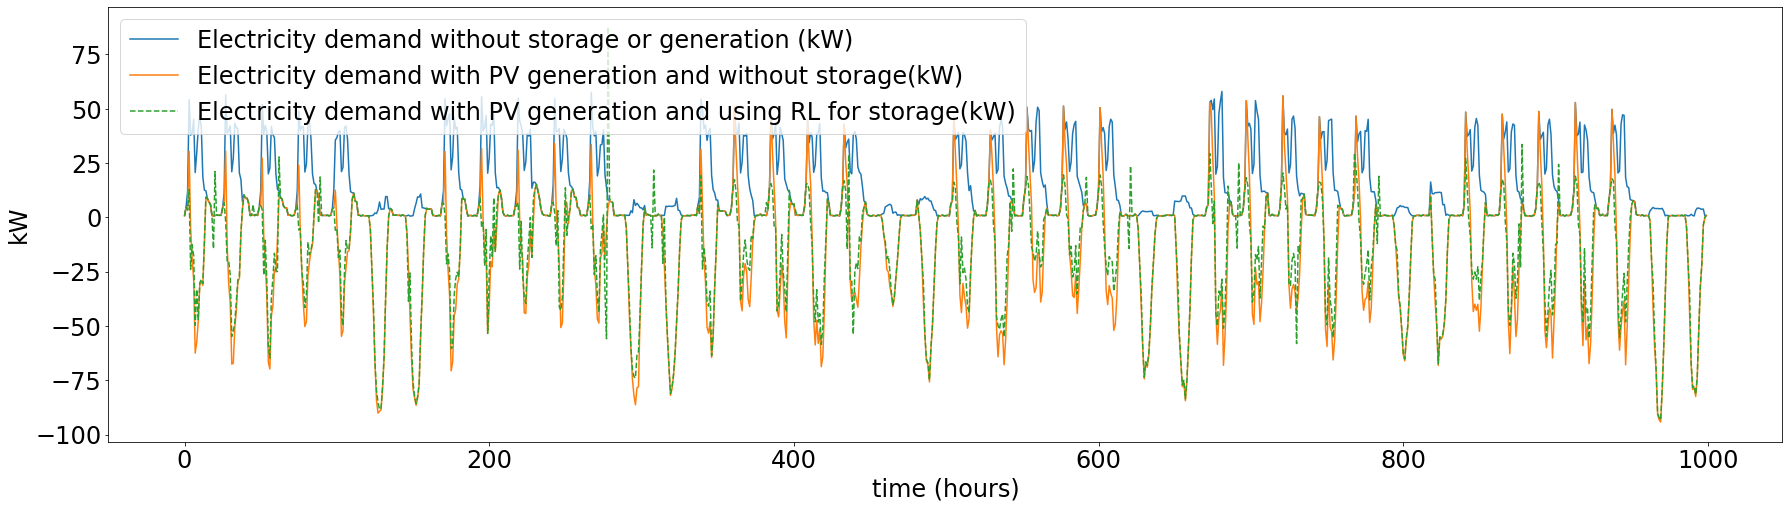

In [79]:
#plot Electricity demand for a short part of the year
sim_period = (4300, 5300)

interval = range(sim_period[0], sim_period[1])

plt.figure(figsize=(30,8))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)', fontsize=24)
plt.ylabel('kW', fontsize=24)
plt.xticks(fontsize= 24)
plt.yticks(fontsize= 24)
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RL for storage(kW)'], fontsize=24)
plt.show()

## RANDOM MODEL

{'ramping': 5.7972665, '1-load_factor': 0.8298081151135822, 'average_daily_peak': 3.7178342, 'peak_demand': 2.5382292, 'net_electricity_consumption': 2.6575742, 'total': 3.1081424473025017, 'coordination_score': 3.2207845149310446}


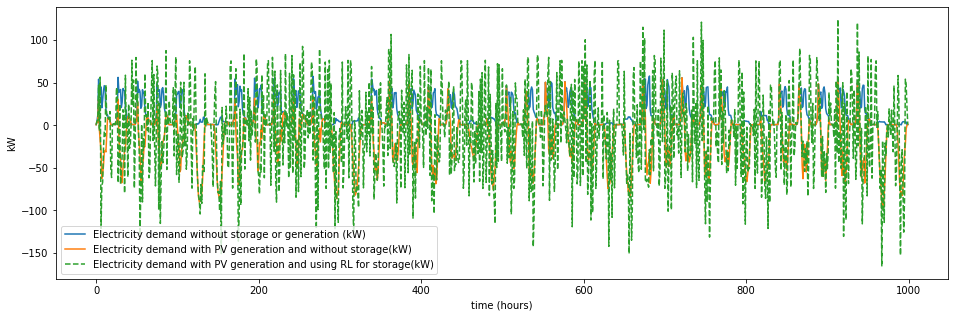

Complete


In [80]:
env.reset()
done = False
while not done:
    action = env.action_space.sample()
    action=[np.array(action, dtype = 'object')]
    next_state, reward, done, _ = env.step(action)
    
    state = next_state

print(env.cost())

interval = range(sim_period[0], sim_period[1])

plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RL for storage(kW)'])
plt.show()


print('Complete')

    